In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [8]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import torch.optim as optim

# Fixed: Added missing __getitem__ method to Dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # This method was missing - crucial for Dataset class
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Add your actual data loading logic here
        # For now, this is a placeholder - you need to implement based on your dataframe structure
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def prepare_data(root_dir, batch_size=32):

    mean = [0.5, 0.5, 0.5]
    std = [0.25, 0.25, 0.25]

    train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),   # أكبر من 5 درجات
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(5, translate=(0.05,0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.25,0.25,0.25])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    train_dataset = datasets.ImageFolder(root=os.path.join(root_dir, 'train'), transform=train_transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(root_dir, 'test'), transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader, train_dataset, test_dataset


In [9]:
import torch.nn.functional as F

class VGG19Explicit(nn.Module):
    def __init__(self, num_classes=1000, batch_norm=False):
        super(VGG19Explicit, self).__init__()

        # Block 1
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64) if batch_norm else None
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64) if batch_norm else None
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128) if batch_norm else None
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128) if batch_norm else None
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256) if batch_norm else None
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256) if batch_norm else None
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_3 = nn.BatchNorm2d(256) if batch_norm else None
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_4 = nn.BatchNorm2d(256) if batch_norm else None
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 4
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512) if batch_norm else None
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512) if batch_norm else None
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_3 = nn.BatchNorm2d(512) if batch_norm else None
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_4 = nn.BatchNorm2d(512) if batch_norm else None
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512) if batch_norm else None
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512) if batch_norm else None
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_3 = nn.BatchNorm2d(512) if batch_norm else None
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_4 = nn.BatchNorm2d(512) if batch_norm else None
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
           nn.Linear(512*7*7, 1024),
           nn.ReLU(True),
           nn.Dropout(0.5),
           nn.Linear(1024, 256),
           nn.ReLU(True),
           nn.Dropout(0.5),
           nn.Linear(256, num_classes)
)



    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1_1(self.conv1_1(x)) if self.bn1_1 else self.conv1_1(x))
        x = F.relu(self.bn1_2(self.conv1_2(x)) if self.bn1_2 else self.conv1_2(x))
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.bn2_1(self.conv2_1(x)) if self.bn2_1 else self.conv2_1(x))
        x = F.relu(self.bn2_2(self.conv2_2(x)) if self.bn2_2 else self.conv2_2(x))
        x = self.pool2(x)

        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)) if self.bn3_1 else self.conv3_1(x))
        x = F.relu(self.bn3_2(self.conv3_2(x)) if self.bn3_2 else self.conv3_2(x))
        x = F.relu(self.bn3_3(self.conv3_3(x)) if self.bn3_3 else self.conv3_3(x))
        x = F.relu(self.bn3_4(self.conv3_4(x)) if self.bn3_4 else self.conv3_4(x))
        x = self.pool3(x)

        # Block 4
        x = F.relu(self.bn4_1(self.conv4_1(x)) if self.bn4_1 else self.conv4_1(x))
        x = F.relu(self.bn4_2(self.conv4_2(x)) if self.bn4_2 else self.conv4_2(x))
        x = F.relu(self.bn4_3(self.conv4_3(x)) if self.bn4_3 else self.conv4_3(x))
        x = F.relu(self.bn4_4(self.conv4_4(x)) if self.bn4_4 else self.conv4_4(x))
        x = self.pool4(x)

        # Block 5
        x = F.relu(self.bn5_1(self.conv5_1(x)) if self.bn5_1 else self.conv5_1(x))
        x = F.relu(self.bn5_2(self.conv5_2(x)) if self.bn5_2 else self.conv5_2(x))
        x = F.relu(self.bn5_3(self.conv5_3(x)) if self.bn5_3 else self.conv5_3(x))
        x = F.relu(self.bn5_4(self.conv5_4(x)) if self.bn5_4 else self.conv5_4(x))
        x = self.pool5(x)

        # Classifier
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x



    def train_model(self, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):

        self.to(device)
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []

        for epoch in range(num_epochs):
        # ======== TRAIN ========
          self.train()
          running_loss = 0.0
          correct = 0
          total = 0

          for images, labels in train_loader:
              images, labels = images.to(device), labels.to(device)

              optimizer.zero_grad()
              outputs = self(images)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

              running_loss += loss.item() * images.size(0)
              _,predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

          epoch_loss = running_loss / total
          epoch_acc = 100 * correct / total
          train_losses.append(epoch_loss)
          train_accuracies.append(epoch_acc)

        # ======== VALIDATION ========
          val_loss, val_acc = self.val_model(val_loader, criterion, device)
          val_losses.append(val_loss)
          val_accuracies.append(val_acc)

          print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # ======== PLOTS ========
        plt.figure(figsize=(12,5))

    # Loss plot
        plt.subplot(1,2,1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()

    # Accuracy plot
        plt.subplot(1,2,2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy over Epochs')
        plt.legend()

        plt.show()

        return train_losses, val_losses, train_accuracies, val_accuracies

    def val_model(self, val_loader, criterion, device='cuda'):
        self.to(device)
        self.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / total
        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        return val_loss, val_accuracy

Using device: cuda
Starting training...
Validation Loss: 0.6548, Validation Accuracy: 73.08%
Epoch [1/7] | Train Loss: 0.7272, Train Acc: 74.10% | Val Loss: 0.6548, Val Acc: 73.08%
Validation Loss: 0.5097, Validation Accuracy: 75.64%
Epoch [2/7] | Train Loss: 0.2977, Train Acc: 88.11% | Val Loss: 0.5097, Val Acc: 75.64%
Validation Loss: 0.6121, Validation Accuracy: 82.69%
Epoch [3/7] | Train Loss: 0.2441, Train Acc: 90.97% | Val Loss: 0.6121, Val Acc: 82.69%
Validation Loss: 0.4956, Validation Accuracy: 83.97%
Epoch [4/7] | Train Loss: 0.2342, Train Acc: 91.18% | Val Loss: 0.4956, Val Acc: 83.97%
Validation Loss: 0.5720, Validation Accuracy: 81.89%
Epoch [5/7] | Train Loss: 0.2002, Train Acc: 93.06% | Val Loss: 0.5720, Val Acc: 81.89%
Validation Loss: 0.9270, Validation Accuracy: 75.00%
Epoch [6/7] | Train Loss: 0.1773, Train Acc: 93.44% | Val Loss: 0.9270, Val Acc: 75.00%
Validation Loss: 1.1411, Validation Accuracy: 77.56%
Epoch [7/7] | Train Loss: 0.1811, Train Acc: 93.25% | Val Los

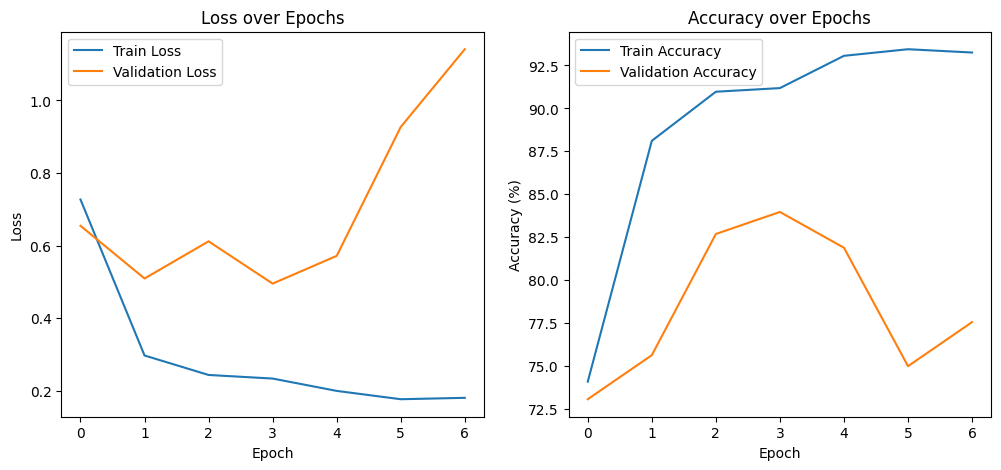

Starting validation...
Validation Loss: 1.1411, Validation Accuracy: 77.56%


In [10]:
# Example usage:
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, train_dataset, test_dataset = prepare_data('/kaggle/input/chest-xray-pneumonia/chest_xray/', batch_size=32)

    # Create model
    num_classes = len(train_dataset.classes)
    model = VGG19Explicit(num_classes=num_classes, batch_norm=True)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)



    # Train model
    print("Starting training...")
    train_losses, val_losses, train_accs, val_accs = model.train_model(
    train_loader, val_loader=test_loader,  # دلوقتي بنستخدم test_loader كـ validation
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=7,
    device=device
)


    # Validate model
    print("Starting validation...")
    val_loss, val_accuracy = model.val_model(test_loader, criterion, device=device)
    scheduler.step(val_accuracy)


In [11]:
#save the model
torch.save(model.state_dict(), 'chest_xray_VGG19_implemented.pth')


In [12]:
# ============================================================
#   EXTRA EVALUATION METRICS (Precision, Recall, F1, CM, ROC)
# ============================================================

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def evaluate_metrics(model, data_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            # Predicted class
            _, preds = torch.max(outputs, 1)

            # Probability for ROC (class 1 only)
            probs = F.softmax(outputs, dim=1)[:, 1]

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # =============================
    # 1. PRECISION - RECALL - F1
    # =============================
    print("\nCLASSIFICATION REPORT:")
    print(classification_report(all_labels, all_preds))

    # =============================
    # 2. CONFUSION MATRIX
    # =============================
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # =============================
    # 3. ROC CURVE + AUC
    # =============================
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print(f"AUC Score: {auc_score:.4f}")


Extra Metrics Evaluation...

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.95      0.42      0.59       234
           1       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.85      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



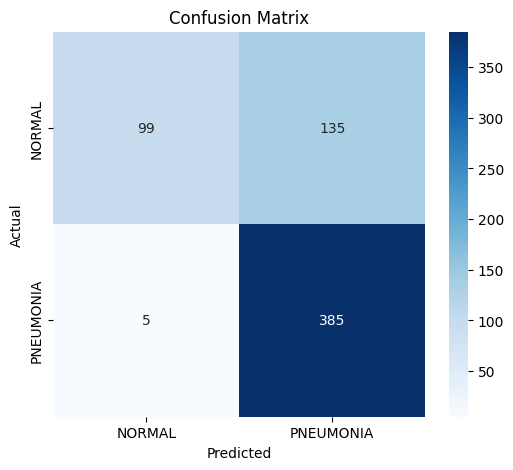

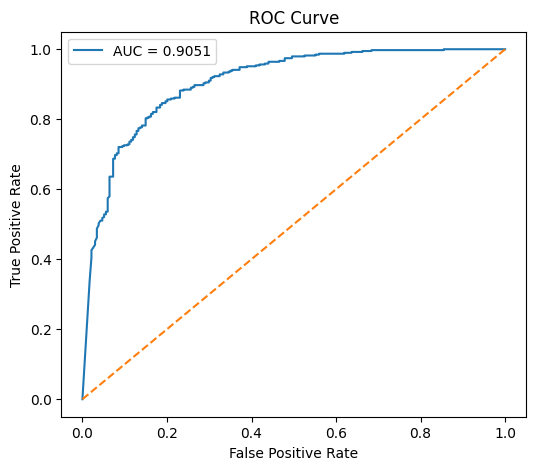

AUC Score: 0.9051


In [13]:
print("Extra Metrics Evaluation...")
evaluate_metrics(model, test_loader, device=device)
